# Entrenamiento: CAPE

Notebook para el entrenamiento del modelo "Cloud Top Height", cuyo trabajo es determinar la altura de las nubes en cada pixel.

Adrián Ramírez <br>
Contanto: felos@ciencias.unam.mx

### Preparando entorno

In [112]:
import os
import sys
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import trainconfig
sys.path.append(trainconfig.DIR_LIB)
sys.path.append(trainconfig.DIR_MODELOS)
import datasets
import modelos

import importlib
importlib.reload(datasets)
importlib.reload(modelos)
importlib.reload(trainconfig)

# Vemos si hay GPUs disponibles, y configuramos para que no use toda la memoria.
trainconfig.ver_gpus()

Name: /physical_device:GPU:0   Type: GPU


### Preparamos el dataset
**(Ver modulo trainconfig)** <br>

Entre las funciones que hace *trainconfig.preparar_dataset()* son: <br>
* Randomiza el orden de los datos
* Separa en train y test
* Normalización (max-min)


In [113]:
trainconfig.preparar_dataset()

Ya existen los datasets preparados,si desea volver a generarlos eliminelos y vulva a ejecutar la función.


### Preparando secuenciador

In [114]:
# ------------------------------------------------------------------

lista_keys_X = ["8","9","10","14","16","Altura","CM"]
lista_keys_y = ["CAPE"]

secuenciador_train = trainconfig.SecuenciaHDF5(
    X_keys = lista_keys_X,
    Y_keys = lista_keys_y,
    batch_size= trainconfig.BATCH_SIZE,
    path_dataset= trainconfig.PATH_DATASET_TRAIN,
)

secuenciador_test = trainconfig.SecuenciaHDF5(
    X_keys = lista_keys_X,
    Y_keys = lista_keys_y,
    batch_size= trainconfig.BATCH_SIZE,
    path_dataset= trainconfig.PATH_DATASET_TEST,
)

### Importamos modelo

In [115]:
modelo = modelos.Modelo_CAPE()
modelo.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 37, 37, 7)]  0           []                               
                                                                                                  
 dense_25 (Dense)               (None, 37, 37, 15)   120         ['input_6[0][0]']                
                                                                                                  
 dense_26 (Dense)               (None, 37, 37, 15)   240         ['dense_25[0][0]']               
                                                                                                  
 dense_27 (Dense)               (None, 37, 37, 15)   240         ['dense_26[0][0]']               
                                                                                            

### Entrenamos modelo

Epoch 1/60
341/341 [==============================] - 107s 312ms/step - loss: 0.0239 - val_loss: 0.0214
Epoch 2/60
341/341 [==============================] - 113s 331ms/step - loss: 0.0221 - val_loss: 0.0212
Epoch 3/60
341/341 [==============================] - 114s 333ms/step - loss: 0.0218 - val_loss: 0.0206
Epoch 4/60
341/341 [==============================] - 116s 339ms/step - loss: 0.0215 - val_loss: 0.0211
Epoch 5/60
124/341 [=========>....................] - ETA: 1:11 - loss: 0.0213Entrenamiento interumpido.


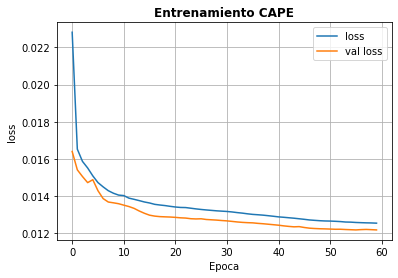

In [116]:
epochs = 60
learning_rate = 0.0006

modelo.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.MeanSquaredError(),
)

try:
    history = modelo.fit(
        secuenciador_train,
        epochs=epochs,
        validation_data=secuenciador_test,
        shuffle=False,
        verbose=1,
    )
except KeyboardInterrupt:
    print("Entrenamiento interumpido.")
    

plt.title("Entrenamiento CAPE",weight="bold")
plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["val_loss"],label="val loss")
plt.xlabel("Epoca")
plt.ylabel("loss")
plt.grid()
plt.legend()

### Guardamos pesos

In [69]:
modelo.save_weights(f"{trainconfig.DIR_PESOS}/CAPE/pesos.tf",save_format="tf")
print(f"Pesos guardados en {trainconfig.DIR_PESOS}/CAPE/pesos.tf")

Pesos guardados en /home/felos/Repos/Deep-GOES/Modelos/Pesos//CAPE/pesos.tf


## Inspección visual resultados

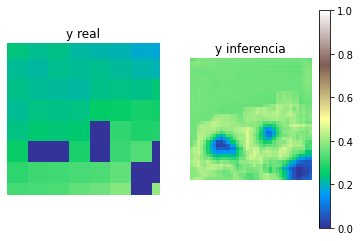

In [107]:
batch = 0
index = 27

x_prueba , y_real = secuenciador_test.__getitem__(batch)

modelo.load_weights(f"{trainconfig.DIR_PESOS}/CAPE/pesos.tf")

y_real = y_real[index,:,:,0]
y_inferencia = modelo(x_prueba).numpy()
y_inferencia = y_inferencia[index]

fig,ax = plt.subplots(1,2)
for i in range(2): ax[i].axis("off")

ax[0].imshow(y_real,vmin=0,vmax=1,cmap="terrain")
ax[0].set_title("y real")
im = ax[1].imshow(y_inferencia,vmin=0,vmax=1,cmap="terrain")
ax[1].set_title("y inferencia")

plt.colorbar(im)